In [1]:
import numpy as np 

from astropy.table import Table
from astropy import units as u 
from astropy.nddata import CCDData, Cutout2D
from astropy.stats import sigma_clipped_stats, sigma_clip

In [2]:
from lcbg.utils import plot_target 
from lcbg.photometry import radial_elliptical_aperture, radial_elliptical_annulus

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['image.origin'] = 'lower'

In [4]:
import ipywidgets as widgets
from IPython.display import display

# Read in catalog 

In [5]:
catalog_filename = "astrodeep_abell370_lcbg_catalog.csv"

In [6]:
lcbg_catalog = Table.read(catalog_filename)

# Load Image

In [7]:
filter_list = ['f105w', 'f125w', 'f140w', 'f160w']

In [8]:
input_data_formatter = "https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch1/hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz.fits"

In [9]:
current_filter =  filter_list[0]
input_data_path = input_data_formatter.format(current_filter)

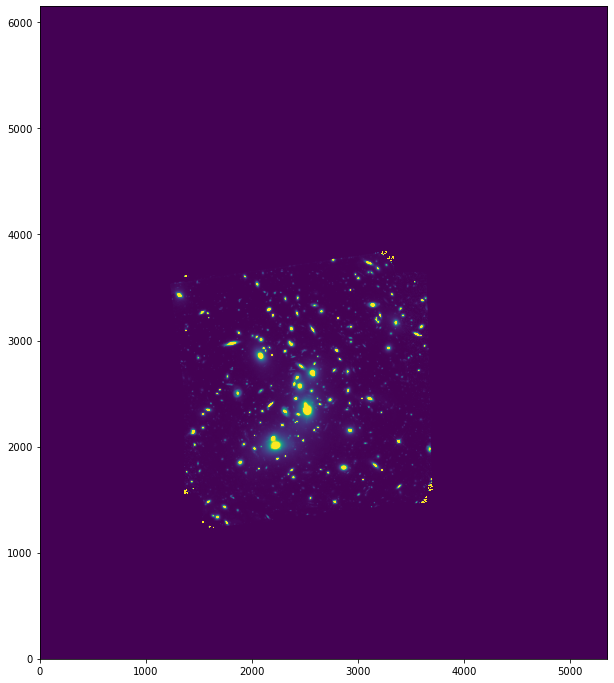

In [10]:
# Load data and vitals
# ---------------------
data = CCDData.read(input_data_path)

plt.imshow(data, vmin=0, vmax=data.data.mean()*10)

0.09194016


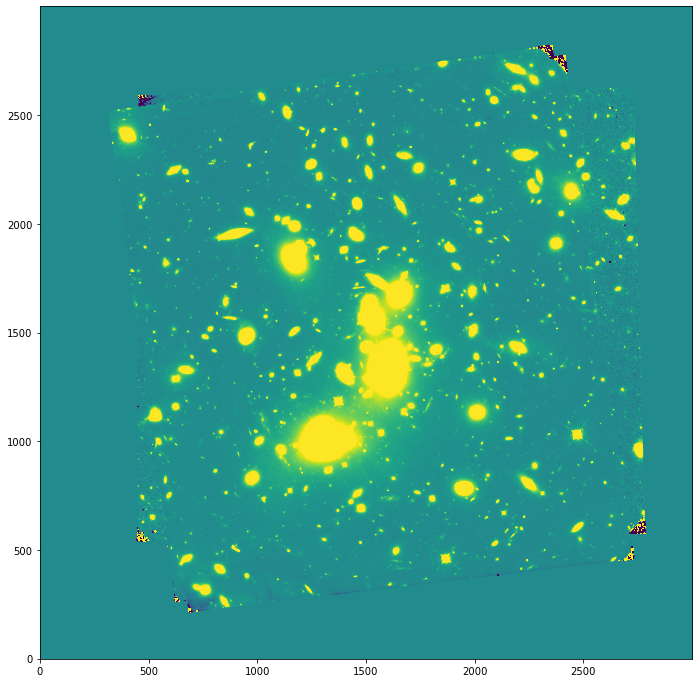

In [11]:
# Cutout Image
# -------------

# Select and crop image:

# Center of cluster:
cx, cy = [int(np.round(i)) for i in data.wcs.world_to_pixel_values(data.header["RA_TARG"], data.header["DEC_TARG"])]
size = 3000

image = Cutout2D(data, (cx, cy), size, copy=True)

# Compute image stats
image_min = image.data.min()
image_max = image.data.max()
image_mean = image.data.mean()
image_sigma = image.data.std()
image_3_sigma = image_sigma * 3.
image_8_sigma = image_sigma * 8.

image_clipped_mean, image_clipped_median, image_clipped_std = sigma_clipped_stats(image.data, sigma=3.0)

# Subtract Noise
image.data  -= image_clipped_mean

# Set min and max values for all plots
vmin = -10 * image_clipped_std
vmax = +10 * image_clipped_std

plt.imshow(image.data, vmin=vmin, vmax=vmax)

print(image_mean)

In [14]:
lcbg_catalog = Table.read(catalog_filename)

In [15]:
# Test photometry function
def slider(x, v):
    vmin = -v * image_clipped_std
    vmax = +v * image_clipped_std
    
    row = lcbg_catalog[x]
    
    obj_e = 1#row['elongation']
    obj_theta = 0#np.deg2rad(row['orientation'])
    
    ra = row['ra']
    dec = row['dec']

    position = [float(i) for i in image.wcs.wcs_world2pix(ra, dec, 0)]
    
    fig, ax = plt.subplots(1, 2, figsize=[16,8])
    plt.sca(ax[0])
    
    plot_target(position, image.data, 100, vmin=vmin, vmax=vmax)
    
    '''
    aperture = radial_elliptical_aperture(position, row['r_total_flux'], e=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', label='R Total')
    aperture = radial_elliptical_aperture(position, row['r_half_light'], e=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', linestyle="-", label='R Half Light')
    aperture = radial_elliptical_aperture(position, row['r20'], e=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', linestyle=':', label='R_20')
    aperture = radial_elliptical_aperture(position, row['r80'], e=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', linestyle=':', label='R_80')
    
    plt.legend()
    '''


    plt.sca(ax[1])
    
    plt.imshow(image.data, vmin=vmin, vmax=vmax, origin='lower')
    aperture = radial_elliptical_aperture(position, 50, e=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', label='R Total')
    
    plt.show()
    
    display(row)


    
widgets.interact(slider, 
                 x=widgets.BoundedIntText(min=0, max=len(lcbg_catalog)-1), 
                 v=widgets.BoundedIntText(5, min=1, max=1000, step=5));

interactive(children=(BoundedIntText(value=0, description='x', max=1), BoundedIntText(value=5, description='v'…